In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Data Description

- **Number of observations:** 196  
- **Number of variables:** 7  

**Variables:**

- `experience` (categorical): Player's experience level, with five categories – Pro, Veteran, Amateur, Regular, Beginner.
- `subscribe` (logical): Whether the player subscribed to the newsletter. This is our **response variable**.
- `played_hours` (numeric): Total number of hours played on the server.
- `age` (numeric): Age of the player.
- `gender` (categorical): Gender of the player.
- `name` (character): First name of the player (not used in prediction).
- `hashedEmail` (character): Anonymized email address (not used in prediction).

### Question 

I will answer Question 1. Specifically, I will use player characteristics including `experience`, `age`, `gender`, and `played_hours` to predict whether a player subscribed to the newsletter (`subscribe`), using a K-Nearest Neighbors (KNN) classification model.

Since some of the predictors are categorical (e.g., `experience`, `gender`), I will use one-hot encoding during preprocessing. The target variable (`subscribe`) is logical, which makes this a classification task.Among the predictors, `experience` and `gender` are categorical variables and will be handled using one-hot encoding. `age` and `played_hours` are numeric variables. The target variable `subscribe` is logical, which makes this a classification task.

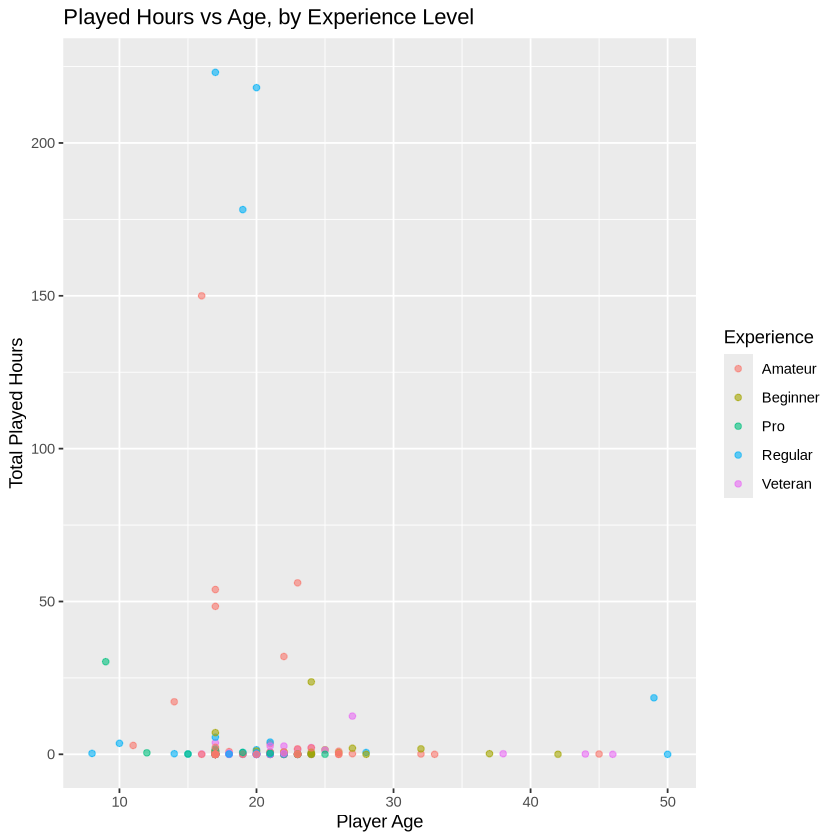

In [3]:
ggplot(drop_na(players, Age, played_hours), aes(x = Age, y = played_hours)) +
  geom_point(aes(color = experience), alpha = 0.6) +
  labs(
    title = "Played Hours vs Age, by Experience Level",
    x = "Player Age",
    y = "Total Played Hours",
    color = "Experience"
  )

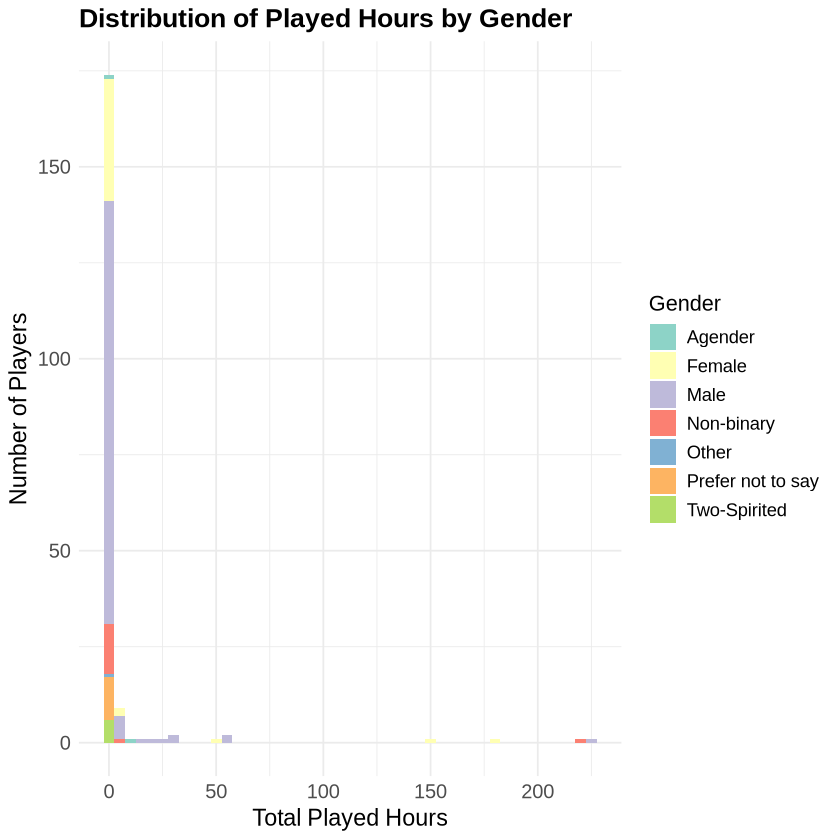

In [4]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(aes(fill = gender), binwidth = 5) +
  labs(
    title = "Distribution of Played Hours by Gender",
    x = "Total Played Hours",
    y = "Number of Players",
    fill = "Gender"
  ) +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 13),
    legend.text = element_text(size = 11)
  )

In [5]:
# Set a seed for reproducibility so that data split results are consistent
set.seed(1234)  
# Convert 'subscribe' to a factor for classification
players <- players |>
  mutate(subscribe = as.factor(subscribe))
# Split the data into training and testing sets (75% train, 25% test)
# Use stratified sampling to preserve the distribution of 'subscribe'
data_split <- initial_split(players, prop = 0.75, strata = subscribe)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [6]:
# Create a preprocessing recipe
# The outcome is 'subscribe' and predictors are age, gender, played_hours, experience
# Center and scale all numeric predictors 
knn_recipe <- recipe(subscribe ~ Age + gender + played_hours + experience, data = training_data) |>
  step_center(all_numeric_predictors()) |>
  step_scale(all_numeric_predictors())

In [7]:
# Specify the K-Nearest Neighbors model
# Set the number of neighbors to 5
# Use the 'kknn' engine and classification
knn_spec <- nearest_neighbor(neighbors = 5) |> 
  set_engine("kknn") |>
  set_mode("classification")

In [8]:
# Create a workflow that combines the preprocessing recipe and the KNN model
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

In [9]:
# Fit the workflow on the training dataset
knn_fit <- fit(knn_workflow, data = training_data)

In [10]:
# Generate predictions using the fitted model on the testing set
knn_pred <- predict(knn_fit, new_data = testing_data) |> 
  bind_cols(select(testing_data, subscribe))  

In [11]:
# Compute evaluation metrics
metrics <- knn_pred |>
  metrics(truth = subscribe, estimate = .pred_class)
# Create a confusion matrix comparing predictions to actual labels
conf_mat <- knn_pred |>
  conf_mat(truth = subscribe, estimate = .pred_class)

metrics
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857
kap,binary,0.1872038


          Truth
Prediction FALSE TRUE
     FALSE     4    5
     TRUE      9   31

## Model Evaluation

The K-Nearest Neighbors classification model achieved an accuracy of **71.4%** and a Kappa value of **0.187** on the testing data. Accuracy indicates that around 71% of the predictions matched the actual values. However, the Kappa value suggests only slight agreement beyond random chance, which means the model may not be very reliable.

The confusion matrix shows the following:

- 31 players who actually subscribed were correctly predicted (True Positives).
- 4 players who did not subscribe were correctly predicted (True Negatives).
- 5 subscribed players were misclassified as not subscribed (False Negatives).
- 9 players who did not subscribe were predicted as subscribers (False Positives).

This imbalance indicates that the model tends to predict “subscribe = TRUE” more often, which may lead to overestimating the number of subscribers.

Based on the model, **player characteristics such as age, experience, gender, and total played hours** were used to predict subscription behavior. The model learned that certain combinations of these features are associated with higher likelihoods of subscribing. For example, experienced players or those with more played hours may be more likely to subscribe.

However, due to the moderate accuracy and low Kappa value, the model's predictions are not entirely reliable. Additional predictors or a different model may improve performance.

In conclusion, although the KNN model reached a moderate level of accuracy, its low Kappa value and confusion matrix analysis suggest that the model does not generalize well. Future improvements could involve testing different classification models (e.g., decision trees, logistic regression) or tuning the number of neighbors (K value). Additionally, collecting more features may help the model capture more predictive patterns.

In this project, I built a K-Nearest Neighbors (KNN) classification model to predict whether a player subscribed to the newsletter based on their age, gender, experience, and total played hours. After preparing the data and training the model, I evaluated its performance using accuracy and Kappa value. The model achieved an accuracy of 71.4% and a Kappa of 0.187 on the testing data. This suggests that the model had moderate accuracy, but the predictions may not be very reliable.

Looking back, I learned how to split data into training and testing sets, create a preprocessing recipe, and build a classification model using tidymodels. I also learned how to interpret evaluation results, including the confusion matrix and performance metrics. These are important steps in any data science project.

One challenge I faced was understanding how to properly preprocess categorical and numeric features. I also had some trouble interpreting the Kappa value at first, but I now understand that it measures how much better the model is than random guessing. If I were to improve the project, I would try using a different classification method like logistic regression or decision trees, and compare the results. I would also try tuning the K value to find the best number of neighbors.

Overall, I found this project helpful for understanding how classification works and how to apply machine learning methods to real data. I feel more confident working with data and using the tidymodels framework.
